# Data Collection

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
import scipy.stats as si
import os

In [3]:
dF = yf.download("ETH-USD", start="2021-03-01", end="2022-03-01")  # download Etherium - USD data for year 2021-2022.

[*********************100%***********************]  1 of 1 completed


In [4]:
dF['Adj Close'].head()  # Display first 5 data entries for Adj Close column.

Date
2021-03-01    1564.707642
2021-03-02    1492.608765
2021-03-03    1575.853149
2021-03-04    1541.914307
2021-03-05    1533.275024
Name: Adj Close, dtype: float64

In [5]:
dF['Adj Close'].tail()  # Displays last 5 data entries for Adj Close column.

Date
2022-02-25    2764.535645
2022-02-26    2781.111816
2022-02-27    2621.801758
2022-02-28    2919.201172
2022-03-01    2972.485107
Name: Adj Close, dtype: float64

In [6]:
normalReturn = []
for i in range(0,len(dF)-1):
    adjclose_yesterday = dF.iloc[i]['Adj Close']
    adjclose_today = dF.iloc[i+1]['Adj Close']
    x = (adjclose_today - adjclose_yesterday) / adjclose_yesterday
    normalReturn.append(x)
normalReturn[:5]    

[-0.04607817782453463,
 0.05577106790286872,
 -0.021536805498695563,
 -0.005602958730816202,
 0.07922032955620155]

In [7]:
logReturn = []
for i in range(0,len(dF)-1):
    adjclose_yesterday = dF.iloc[i]['Adj Close']
    adjclose_today = dF.iloc[i+1]['Adj Close']
    y = np.log(adjclose_today / adjclose_yesterday)
    logReturn.append(y)
logReturn[:5]

[-0.047173558296895124,
 0.05427137002269247,
 -0.021772107057521358,
 -0.005618714183079258,
 0.07623886335092327]

In [8]:
dFnr = pd.DataFrame(normalReturn, columns = ['normal']) 
nor_ret = dFnr.mean() * len(dFnr)
nor_vol = dFnr.std() * (len(dFnr) ** 0.5)
print('The annulized normal return is %.8f and its annulized volatility is %.8f' % (nor_ret,nor_vol))

The annulized normal return is 1.12888001 and its annulized volatility is 0.98356271


In [9]:
dFlr = pd.DataFrame(logReturn, columns = ['log']) 
log_ret = dFlr.mean() * len(dFlr)
log_vol = dFlr.std() * (len(dFlr) ** 0.5)
print('The annulized log return is %.8f and its annulized volatility is %.8f' % (log_ret,log_vol))

The annulized log return is 0.64169934 and its annulized volatility is 0.99098769


# Methodology

# Binomial Tree

In [10]:
logRet = np.log(dF['Adj Close'] / dF['Adj Close'].shift(1))
vol = np.sqrt(365) * logRet.std() 
vol     # diffusion coefficient or volatility 

0.9909876947436332

In [11]:
stock_price = 2972.48                 # spot stock price
strike_price = 2970                  # strike price
time = 1                            # maturity 
risk = 1.58                        # risk free rate from Bloomberg 30th March
Num = 3                           # number of periods or number of time steps  
payoff = "call"                  # payoff 

In [12]:
dT = float(time) / Num                           # Delta t
uf = np.exp(vol * np.sqrt(dT))                   # up factor
df = 1.0 / uf                                    # down factor

In [13]:
S = np.zeros((Num + 1, Num + 1))
S[0, 0] = stock_price
z = 1
for t in range(1, Num + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * uf
        S[i+1, t] = S[i, t-1] * df
    z += 1
S

array([[ 2972.48      ,  5267.43556225,  9334.25200588, 16540.92574643],
       [    0.        ,  1677.40777196,  2972.48      ,  5267.43556225],
       [    0.        ,     0.        ,   946.58225906,  1677.40777196],
       [    0.        ,     0.        ,     0.        ,   534.16824946]])

In [14]:
a = np.exp(risk * dT)    # risk free compound return
p = (a - df)/ (uf - df)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.9347640974038663

In [15]:
q

0.06523590259613365

In [16]:
S_T = S[:,-1]
V = np.zeros((Num + 1, Num + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-strike_price, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(strike_price-S_T, 0.0)
V

array([[    0.        ,     0.        ,     0.        , 13570.92574643],
       [    0.        ,     0.        ,     0.        ,  2297.43556225],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ]])

In [17]:
# For European Option
for j in range(Num-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-risk*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 2364.0506563 ,  4233.49763526,  7580.25833395, 13570.92574643],
       [    0.        ,   700.14909559,  1268.28523254,  2297.43556225],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ]])

In [18]:
print('European ' + payoff + ':', str( V[0,0]))

European call: 2364.050656299018


# Monte Carlo Simulation

In [19]:
def mcs_simulation(p):
    nts = p                             #number of time step
    ns = p                             #number of simulation
    dt = time / nts                   #size of timestep
    S = np.zeros((nts + 1, ns))
    S[0] = stock_price              #starting point
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, nts + 1): 
        S[t] = S[t-1] * np.exp((risk - vol ** 2 / 2) * dt + vol * np.sqrt(dt) * rn[t]) 
    return S

In [20]:
S = mcs_simulation(10000)

In [21]:
S = np.transpose(S)
S

array([[ 2972.48      ,  3004.21078128,  3042.34799934, ...,
         6052.27490255,  6034.78681268,  6056.14820619],
       [ 2972.48      ,  2971.27061985,  2953.42613688, ...,
         8006.33222332,  7921.97994317,  7875.45984102],
       [ 2972.48      ,  2961.48658029,  2984.03994734, ...,
         5818.12109588,  5913.0966853 ,  5956.70394189],
       ...,
       [ 2972.48      ,  2980.71567328,  2991.44463561, ...,
        18342.70935149, 18089.65035089, 17993.98036978],
       [ 2972.48      ,  2970.49007854,  2941.12804115, ...,
         6700.47730492,  6542.81008267,  6429.75656365],
       [ 2972.48      ,  2959.56166496,  2980.43017846, ...,
         3315.97771811,  3272.06273433,  3220.46764288]])

Text(0.5, 1.0, 'Frequency distribution of the simulated values')

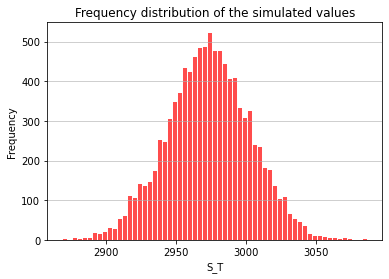

In [22]:
n, bins, patches = mpl.hist(x=S[:,1], bins='auto', color='#ff0000',alpha=0.7, rwidth=0.85)

mpl.grid(axis='y', alpha=0.75)
mpl.xlabel('S_T')
mpl.ylabel('Frequency')
mpl.title('Frequency distribution of the simulated values')

In [23]:
c = np.mean(np.maximum(S[:,-1] - strike_price,0)) * np.exp(- risk * time)
print('European call:', str(c))

European call: 2338.775969101706


In [24]:
cp = (S[-1,:]  - strike_price)>0
bpc = np.mean(np.maximum(cp.astype(int),0))
print('Binary call: ', str(bpc))

Binary call:  0.946005399460054


In [25]:
pp = (strike_price - S[-1,:])>0
bpp = np.mean(np.maximum(pp.astype(int),0))
print('Binary put: ', str(bpp))

Binary put:  0.05399460053994601


In [26]:
bpc + bpp

1.0

# Black-Scholes Model

In [27]:
def bsm(stock_price, strike_price, time, risk, vol, payoff):
    
    # stock_price: spot price
    # strike_price: strike price
    # time: time to maturity
    # risk: risk free rate
    # vol: volatility of underlying asset
    # payoff: call or put
    
    b1 = (np.log(stock_price / strike_price) + (risk + 0.5 * vol ** 2) * time) / (vol * np.sqrt(time))
    b2 = (np.log(stock_price / strike_price) + (risk + 0.5 * vol ** 2) * time) / (vol * np.sqrt(time))
    if payoff == "call":
        option_value = stock_price * si.norm.cdf(b1, 0.0, 1.0) - strike_price * np.exp(-risk * time) * si.norm.cdf(b2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - stock_price * si.norm.cdf(-b1, 0.0, 1.0) + strike_price * np.exp(-risk * time) * si.norm.cdf(-b2, 0.0, 1.0)
    
    return option_value

In [28]:
print('European call:',bsm(2972.48, 2970, 1, 1.58, 0.99, 'call'))

European call: 2317.702300066436


# Analysis

# GREEKS

# Delta

In [29]:
    # stock_price: spot price
    # strike_price: strike price
    # time: time to maturity
    # risk: risk free rate
    # div: continuous dividend yield
    # vol: volatility of underlying asset
    # payoff: call or put

In [30]:
def delta(stock_price, strike_price, time, risk, div, vol, payoff):
    
    d1 = (np.log(stock_price / strike_price) + (risk - div + 0.5 * vol ** 2) * time) / (vol * np.sqrt(time))
    d2 = (np.log(stock_price / strike_price) + (risk - div + 0.5 * vol ** 2) * time) / (vol * np.sqrt(time))
    if payoff == "call":
        delta = np.exp(- div * time) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(- div * time) * si.norm.cdf(- d1, 0.0, 1.0)
    
    return delta

In [55]:
d = delta(2972.48, 2970, 1, 1.58, 0, 0.99, 'call')
print('The value of Delta is', d.round(4),'.','If the stock price increase 1 dollar, then the value of the option will increase $', d.round(4), '.')

The value of Delta is 0.9818 . If the stock price increase 1 dollar, then the value of the option will increase $ 0.9818 .


In [32]:
S = np.linspace(2600, 3200, 51)
T = np.linspace(0.5, 2.0, 51)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 2970, T[i], 1.58, 0, 0.99, 'call')

C:\Users\sukhi\AppData\Local\Temp/ipykernel_23676/2066602291.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


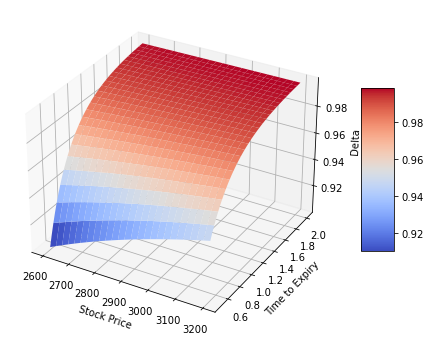

In [33]:
fig = mpl.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=mpl.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Gamma

In [34]:
def gamma(stock_price, strike_price, time, risk, div, vol, payoff):
    
    g1 = (np.log(stock_price / strike_price) + (risk - div + 0.5 * vol ** 2) * time) / (vol * np.sqrt(time))
    gamma = np.exp(- div * time) * si.norm.pdf(g1, 0.0, 1.0) / (vol * stock_price * np.sqrt(time))
    
    return gamma

In [35]:
print('Gamma value:', gamma(2972.48, 2970, 1, 1.58, 0, 0.99, 'call'))

Gamma value: 1.5205408733156844e-05


In [36]:
S = np.linspace(50, 150, 51)
T = np.linspace(0.5, 2, 51)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 2970, T[i], 1.58, 0, 0.99, 'call')

C:\Users\sukhi\AppData\Local\Temp/ipykernel_23676/843596607.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


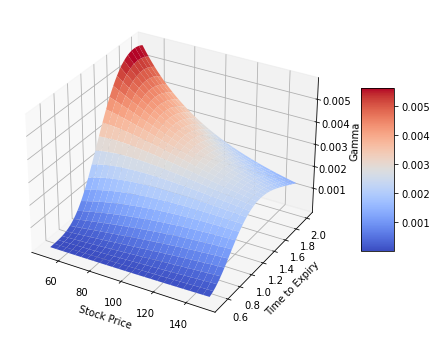

In [37]:
fig = mpl.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=mpl.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Speed

In [38]:
def speed(stock_price, strike_price, time, risk, div, vol, payoff):
    
    s1 = (np.log(stock_price / strike_price) + (risk - div + 0.5 * vol ** 2) * time) / (vol * np.sqrt(time))
    speed = - np.exp(- div * time) * si.norm.pdf(s1, 0.0, 1.0) / ((vol **2) * (stock_price**2) * np.sqrt(time)) * (s1 + vol * np.sqrt(time))
    
    return speed

In [39]:
print('Speed value:', speed(2972.48, 2970, 1, 1.58, 0, 0.99, 'call'))

Speed value: -1.5923876242859742e-08


In [40]:
S = np.linspace(2600, 3200, 51)
T = np.linspace(1, 10, 11)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 2970, T[i], 1.58, 0, 0.99, 'call')

C:\Users\sukhi\AppData\Local\Temp/ipykernel_23676/3633481857.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


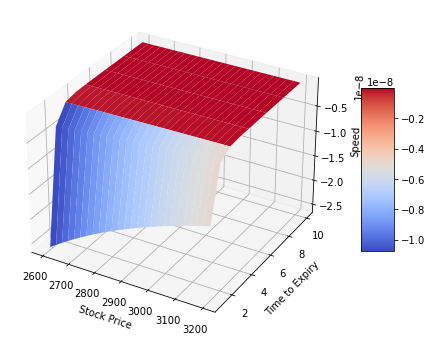

In [41]:
fig = mpl.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=mpl.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Theta

In [42]:
def theta(stock_price, strike_price, time, risk, div, vol, payoff):
    
    t1 = (np.log(stock_price / strike_price) + (risk - div + 0.5 * vol ** 2) * time) / (vol * np.sqrt(time))
    t2 = (np.log(stock_price / strike_price) + (risk - div - 0.5 * vol ** 2) * time) / (vol * np.sqrt(time))
    if payoff == "call":
        theta = vol * stock_price * np.exp(- div * time) * si.norm.pdf(t1, 0.0, 1.0) / (2 * np.sqrt(time)) - div * stock_price * np.exp(-div * time) * si.norm.cdf(t1, 0.0, 1.0) + risk * strike_price * np.exp(-risk * time) * si.norm.cdf(t2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * stock_price * np.exp(- div * time) * si.norm.pdf(-t1, 0.0, 1.0) / (2 * np.sqrt(time)) - div * stock_price * np.exp(-div * time) * si.norm.cdf(-t1, 0.0, 1.0) + risk * strike_price * np.exp(-risk * time) * si.norm.cdf(-t2, 0.0, 1.0)
    
    return theta

In [43]:
print('Theta value:', theta(2972.48, 2970, 1, 1.58, 0, 0.99, 'call'))

Theta value: 901.6467011912454


In [44]:
S = np.linspace(2600, 3200, 51)
T = np.linspace(0.5, 2, 51)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 2970, T[i], 1.58, 0, 0.99, 'call')

C:\Users\sukhi\AppData\Local\Temp/ipykernel_23676/3701339239.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


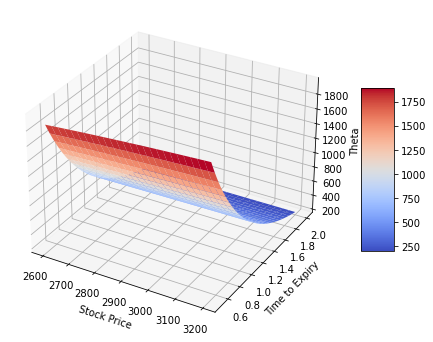

In [45]:
fig = mpl.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=mpl.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Rho

In [46]:
def rho(stock_price, strike_price, time, risk, div, vol, payoff):
    
    r1 = (np.log(stock_price / strike_price) + (risk - div + 0.5 * vol ** 2) * time) / (vol * np.sqrt(time))
    r2 = (np.log(stock_price / strike_price) + (risk - div - 0.5 * vol ** 2) * time) / (vol * np.sqrt(time))
    if payoff == "call":
        rho =  strike_price * time * np.exp(-risk * time) * si.norm.cdf(r2, 0.0, 1.0)
    elif payoff == "put":
        rho = - strike_price * time * np.exp(-risk * time) * si.norm.cdf(-r2, 0.0, 1.0)
    
    return rho

In [47]:
print('Rho value:',rho(2972.48, 2970, 1, 1.58, 0, 0.99, 'call'))

Rho value: 528.9928733071501


In [48]:
S = np.linspace(50, 150, 51)
T = np.linspace(0.5, 2, 51)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 2970, T[i], 1.58, 0, 0.99, 'call')

C:\Users\sukhi\AppData\Local\Temp/ipykernel_23676/2989394863.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


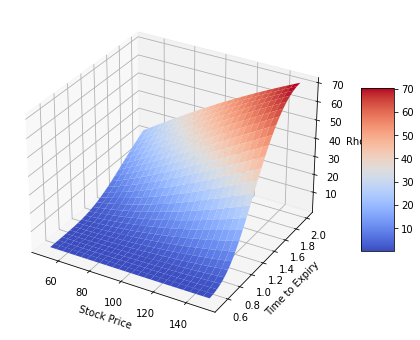

In [49]:
fig = mpl.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=mpl.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Vega

In [50]:
def vega(stock_price, strike_price, time, risk, div, vol, payoff):
    
    v1 = (np.log(stock_price / strike_price) + (risk - div + 0.5 * vol ** 2) * time) / (vol * np.sqrt(time))
    vega = stock_price * np.sqrt(time) * np.exp(-div * time) * si.norm.pdf(v1, 0.0, 1.0)
    
    return vega

In [51]:
print('Vega value:',vega(2972.48, 2970, 1, 1.58, 0, 0.99, 'call'))

Vega value: 133.00598255747116


In [52]:
S = np.linspace(2600, 3200, 51)
T = np.linspace(0.5, 2, 51)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 2970, T[i], 1.58, 0, 0.99, 'call')

C:\Users\sukhi\AppData\Local\Temp/ipykernel_23676/3038454507.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


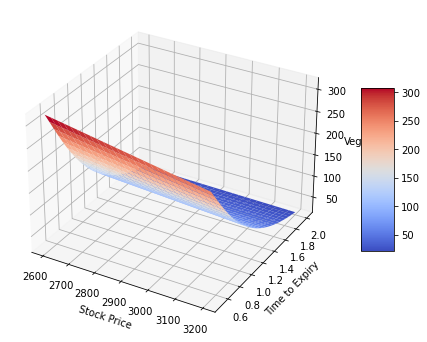

In [53]:
fig = mpl.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=mpl.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [54]:
v = vega(2972.48, 2970, 1, 1.58, 0, 0.99, 'call')
print('The value of Vega is', v.round(4),'.','If the volatility increases 1%, then the value of the option will increase $', v.round(4)*0.01,'.')

The value of Vega is 133.006 . If the volatility increases 1%, then the value of the option will increase $ 1.33006 .
